# Stock Prices Predication using LSTM

## IMPORT

In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## PREPROCESSING

In [2]:
# Load csv
df = pd.read_csv('../input/cac40-stocks-dataset/preprocessed_CAC40.csv', parse_dates=['Date'])

In [3]:
df.head(5)

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


In [4]:
def load_data(company, start, end):
    """
    Load data for the specified company and date range.

    :param company: The company's stock symbol (str)
    :param start: The starting date for the data range (str or datetime)
    :param end: The ending date for the data range (str or datetime)
    :return: A dataframe containing the relevant stock data (pandas.DataFrame)
    """
    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.Name == company, :]
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    dataframe = dataframe.rename(columns = {'Closing_Price': 'Close'})
    return dataframe

In [5]:
COMPANY = 'Accor'
START_DATE = dt.datetime(2015,1,1)
END_DATE = dt.datetime(2020,1,1)

START_DATE_TEST = END_DATE

In [6]:
data = load_data(company = COMPANY,
                 start = START_DATE,
                 end = END_DATE)

In [7]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [9]:
# Set the number of days used for prediction
prediction_days = 60

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

## LSTM MODEL
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. Introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network.

In [10]:
def LSTM_model():
    """
    Create and configure an LSTM model for stock price prediction.

    :return: The configured LSTM model (keras.Sequential)
    """

    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

## TRAINING

In [11]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam', 
    loss='mean_squared_error'
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [12]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5', 
    verbose = 2, 
    save_best_only = True
)

model.fit(
    x_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25
38/38 [==============================] - 7s 75ms/step - loss: 0.0704
Epoch 2/25
38/38 [==============================] - 3s 76ms/step - loss: 0.0122
Epoch 3/25
38/38 [==============================] - 3s 74ms/step - loss: 0.0089
Epoch 4/25
38/38 [==============================] - 3s 75ms/step - loss: 0.0089
Epoch 5/25
38/38 [==============================] - 3s 75ms/step - loss: 0.0087
Epoch 6/25
38/38 [==============================] - 3s 77ms/step - loss: 0.0077
Epoch 7/25
38/38 [==============================] - 3s 75ms/step - loss: 0.0084
Epoch 8/25
38/38 [==============================] - 3s 75ms/step - loss: 0.0071
Epoch 9/25
38/38 [==============================] - 3s 81ms/step - loss: 0.0074
Epoch 10/25
38/38 [==============================] - 3s 76ms/step - loss: 0.0071
Epoch 11/25
38/38 [==============================] - 3s 74ms/step - loss: 0.0071
Epoch 12/25
38/38 [==============================] - 3s 74ms/step - loss: 0.0067
Epoch 13/25
38/38 [==================

## INFERENCE

In [13]:
# Load test data for the specified company and date range
test_data = load_data(
    company=COMPANY,
    start=START_DATE_TEST,
    end=dt.datetime.now()
)

# Extract the actual closing prices from the test data
actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)

In [14]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

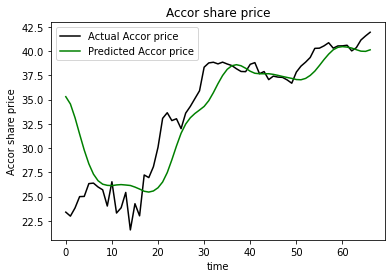

In [15]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted {COMPANY} price")

# Set the title of the plot using the company name
plt.title(f"{COMPANY} share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"{COMPANY} share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [16]:
# Extract the last 'prediction_days' values from the model inputs
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data)

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")

Prediction: 40.4481086730957


## Forecasting techniques

In [63]:
# Regular libraries for data manipulation
import pprint
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Visualization
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tools for time series analysis
from scipy import signal
import statsmodels.api as sm
# from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

from pylab import rcParams

In [32]:
# Filtering the dataframe to focus on Air Liquide stocks
air_liquide = df[df['Name'] == 'Air Liquide'].copy()

# Converting the 'Date' column to a datetime object
air_liquide['Date'] = pd.to_datetime(air_liquide['Date'])

# Extracting year and month from the 'Date' column and adding them as separate columns
air_liquide['Year'] = air_liquide['Date'].dt.year
air_liquide['Month'] = air_liquide['Date'].dt.month

# Printing the shape of the 'air_liquide' dataframe
print(f'air_liquide shape: {air_liquide.shape[0]} rows, {air_liquide.shape[1]} columns')

air_liquide shape: 2600 rows, 10 columns


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


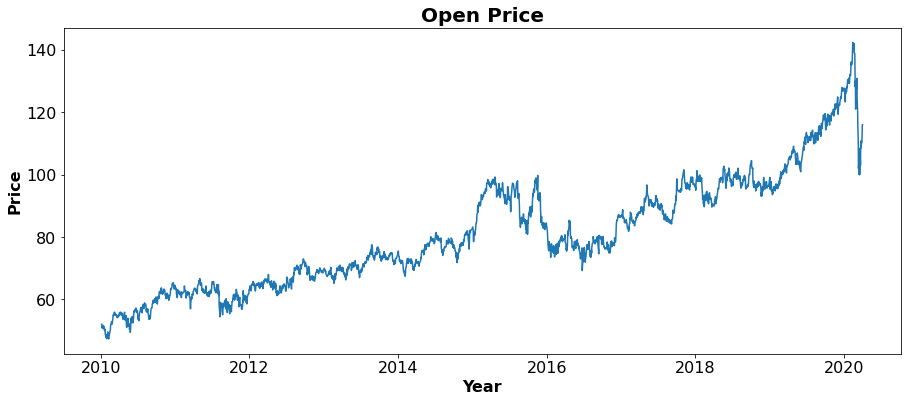

In [33]:
# Line plot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(air_liquide['Date'], air_liquide['Open'] )

# Formatting
ax.set_title('Open Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

# Adjusting tick label sizes for better readability
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

In [34]:
# Check the number of NaN values in each column of the dataframe
air_liquide.isna().sum()

Unnamed: 0         0
Name               0
Date               0
Open               1
Closing_Price      0
Daily_High         0
Daily_Low          0
Volume           134
Year               0
Month              0
dtype: int64

In [35]:
# Retrieve the index of the missing value in the 'Open' column
index_open_missing = air_liquide[pd.isnull(air_liquide['Open'])].index
print("index of the missing value in the Open column:", list(index_open_missing)[0])

index of the missing value in the Open column: 4538


In [36]:
# Replace the missing value in the 'Open' column with the value from the previous day (backward fill)
air_liquide['Open'] = air_liquide['Open'].fillna(method='bfill')

# Calculate and print the percentage of missing values in the 'Volume' column
print(f"Percentage of missing values in Volume: {round(sum(pd.isnull(air_liquide['Volume']))/air_liquide.shape[0],2)}\n")
print(air_liquide[air_liquide['Volume']==0])

Percentage of missing values in Volume: 0.05

Empty DataFrame
Columns: [Unnamed: 0, Name, Date, Open, Closing_Price, Daily_High, Daily_Low, Volume, Year, Month]
Index: []


In [39]:
# Missing values in the 'Volume' column are replaced by 0
imputer = SimpleImputer(strategy='constant', fill_value=0)
air_liquide_plus = imputer.fit_transform(air_liquide)

# Imputation removed column names; put them back
imputed_air_liquide = pd.DataFrame(air_liquide_plus)

# Create a new dataframe with imputed values
imputed_air_liquide.columns = air_liquide.columns

In [40]:
# Replace comma by period so Volume can be converted to float
imputed_air_liquide['Volume'] = imputed_air_liquide['Volume'].apply(lambda x : str(x))
imputed_air_liquide['Volume'] = pd.to_numeric(imputed_air_liquide['Volume'].apply(lambda x : x.replace(',','',1)))

# Convert object type columns to numeric 
imputed_air_liquide['Open'] = pd.to_numeric(imputed_air_liquide['Open'])
imputed_air_liquide['Closing_Price'] = pd.to_numeric(imputed_air_liquide['Closing_Price'])
imputed_air_liquide['Daily_High'] = pd.to_numeric(imputed_air_liquide['Daily_High'])
imputed_air_liquide['Daily_Low'] = pd.to_numeric(imputed_air_liquide['Daily_Low'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


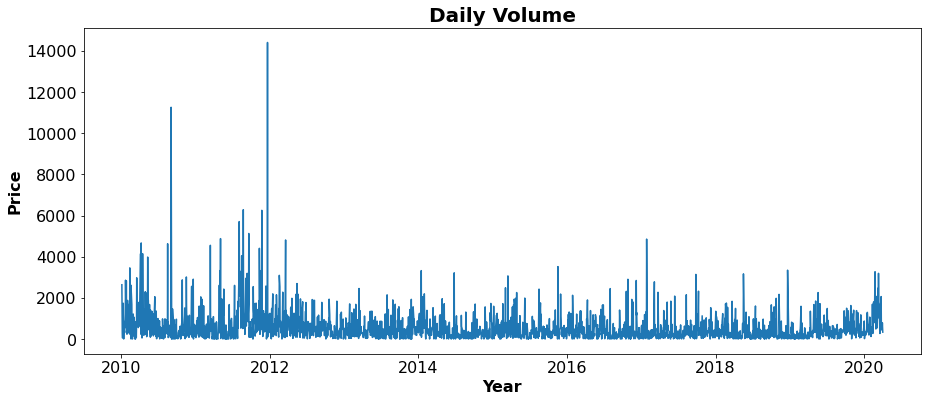

In [41]:
# Plot Daily Volume Lineplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(imputed_air_liquide['Date'], imputed_air_liquide['Volume'] )

# Formatting
ax.set_title('Daily Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


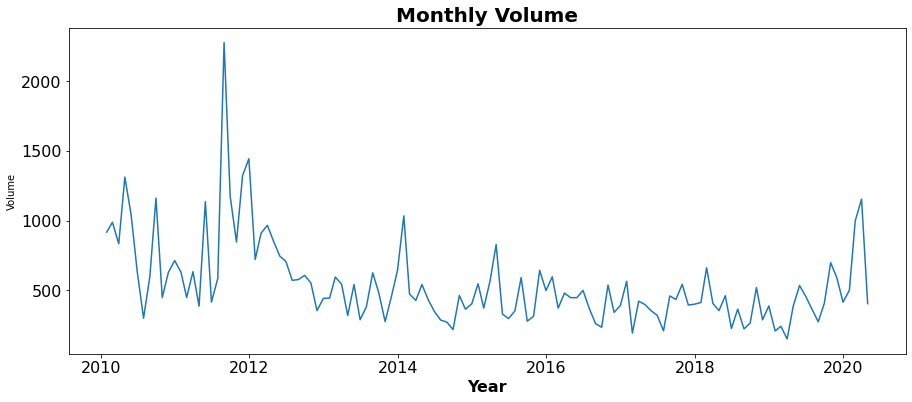

In [42]:
# Create a copy of the 'Date' and 'Volume' columns
y = imputed_air_liquide[['Date','Volume']].copy()

# Set the index to 'Date' and convert it to datetime format
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)

# Resample the time series to monthly and compute the mean of each month
y = y.resample('1M').mean()

# Add the 'Date' column back to the DataFrame
y['Date'] = y.index

# Plot the monthly volume time series
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(y['Date'], y['Volume'] )

# Set the title and axes labels
ax.set_title('Monthly Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

## SEASONALITY

In [43]:
imputed_air_liquide['Year'] = imputed_air_liquide['Date'].dt.year
imputed_air_liquide['Month'] = imputed_air_liquide['Date'].dt.month

In [44]:
print(imputed_air_liquide['Year'].unique())

[2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010]


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


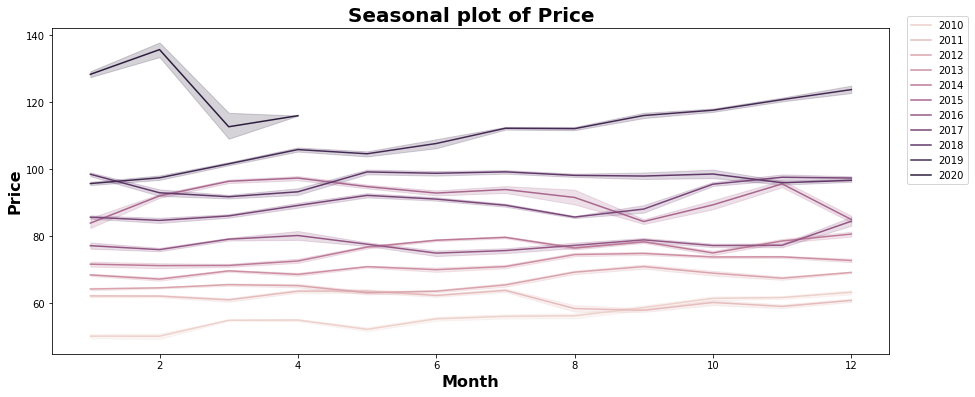

In [45]:
# Set the variable to plot
variable = 'Open'

# Create a figure with one plot
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the seasonal line plot
sns.lineplot(imputed_air_liquide['Month'], imputed_air_liquide[variable], hue = imputed_air_liquide['Year'])

# Format the plot
ax.set_title('Seasonal plot of Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2010+i) for i in range(11)], bbox_to_anchor=(1.1, 1.05))

## TIME SERIES

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


Text(0.5, 0.98, 'Open decomposition')

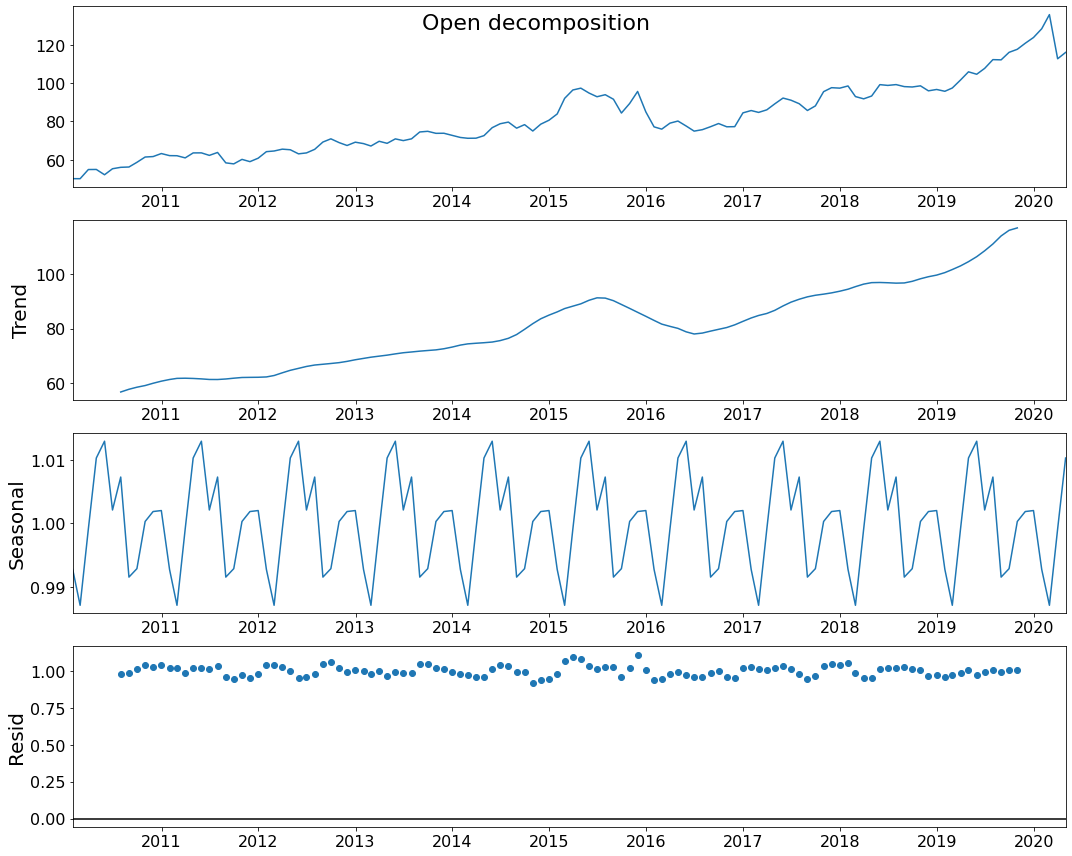

In [50]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date', 'Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Setting rcparams for plot size and font size
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16

# Using statistical tools of statsmodel library to perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative', freq=12)

# Plotting the decomposition
decomp = decomposition.plot()
decomp.suptitle('Open decomposition', fontsize=22)

## STATIONARITY

In [53]:

from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [51]:
def adf_test(series, title=''):
    """
    Perform the Augmented Dickey-Fuller test on a time series.

    Parameters:
        series (pd.Series): The time series to be tested.
        title (str): Optional title to be displayed in the results.

    Returns:
        None

    Prints an ADF report that includes the following statistics:
    - ADF test statistic
    - p-value
    - Number of lags used
    - Number of observations
    - Critical values at 1%, 5%, and 10% significance levels

    Also prints a conclusion about the stationarity of the series based on the p-value.

    Example:
        >>> adf_test(y['Open'], title='Open Prices')
    """
    
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series.dropna(),autolag='AIC') 
    
    # Create a Series object with the test statistics and critical values
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    
    # Add the critical values to the Series object
    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # Print the ADF report
    print(out.to_string())          
    
    # Check for stationarity based on the p-value
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [54]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Perform the ADF test on the Open prices
adf_test(y['Open'],title='')

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.196686
p-value                   0.938915
# lags used               2.000000
# observations          121.000000
critical value (1%)      -3.485585
critical value (5%)      -2.885739
critical value (10%)     -2.579676
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


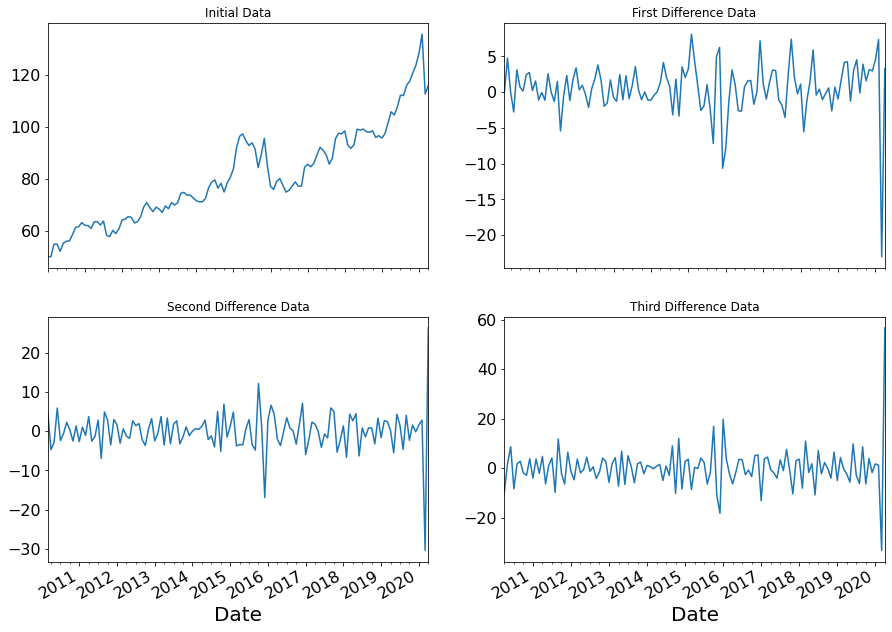

In [55]:
# Create a 2x2 grid of subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

# Apply differencing to the 'Open' column and add it to the dataframe
y['OpenDiff1'] = diff(y['Open'], k_diff=1)
y['OpenDiff2'] = diff(y['Open'], k_diff=2)
y['OpenDiff3'] = diff(y['Open'], k_diff=3)

# Plot the initial 'Open' data on the first subplot
y['Open'].plot(title="Initial Data", ax=ax[0][0]).autoscale(axis='x', tight=True);

# Plot the first difference data on the second subplot
y['OpenDiff1'].plot(title="First Difference Data", ax=ax[0][1]).autoscale(axis='x', tight=True);

# Plot the second difference data on the third subplot
y['OpenDiff2'].plot(title="Second Difference Data", ax=ax[1][0]).autoscale(axis='x', tight=True);

# Plot the third difference data on the fourth subplot
y['OpenDiff3'].plot(title="Third Difference Data", ax=ax[1][1]).autoscale(axis='x', tight=True);

# Rotate the x-axis labels to make them easier to read
fig.autofmt_xdate()

## AUTO CORRELATION

[1.         0.99669167 0.99397744 0.99114807 0.98842329 0.98574882
 0.98327505 0.98065432 0.97792933 0.97569862 0.97316217 0.97091567
 0.96872365 0.96677005 0.96448024 0.96224729 0.95968184 0.95699272
 0.95423987 0.95126885 0.94815404 0.94479836 0.94160485 0.93854499
 0.93560843 0.93284805 0.92976929 0.92688093 0.92378304 0.92046489
 0.91730545 0.91394706 0.91064856 0.90743726 0.90426107 0.90102265
 0.89772752 0.89464738 0.89163062 0.88862379 0.88584496 0.88294789
 0.88021878 0.87768629 0.87519469 0.87266679 0.87039248 0.86809038
 0.86572663 0.86328034 0.86084315 0.85844897 0.85612914 0.85390287
 0.85154451 0.84929882 0.84707093 0.84483261 0.84257198 0.84030894
 0.83812315]


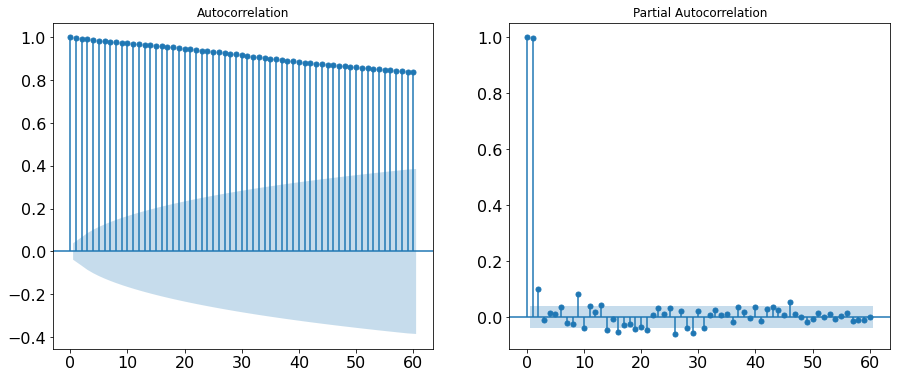

In [56]:
# Creating a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 6))

# Calculating autocorrelation function (ACF) with 60 lags for Open prices
autocorr = acf(imputed_air_liquide['Open'], nlags=60, fft=False)
print(autocorr)

# Plotting the ACF with 60 lags on the first subplot
plot_acf(imputed_air_liquide['Open'].tolist(), lags=60, ax=ax[0], fft=False);

# Plotting the partial autocorrelation function (PACF) with 60 lags on the second subplot
plot_pacf(imputed_air_liquide['Open'].tolist(), lags=60, ax=ax[1]);

## MOVING AVERAGE

<AxesSubplot:xlabel='Date'>

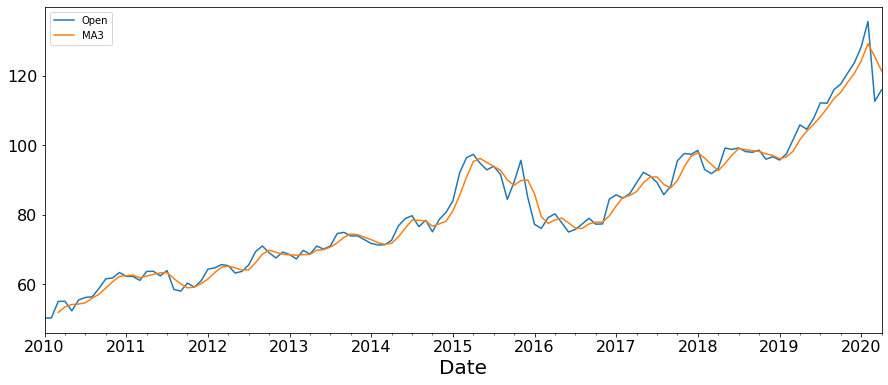

In [57]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Compute rolling mean with window size of 3
y['MA3'] = y.rolling(window=3).mean() 

# Plot the resulting time series
y.plot(figsize=(15,6))

## EXPONENTIAL SMOOTHING

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


<AxesSubplot:xlabel='Date'>

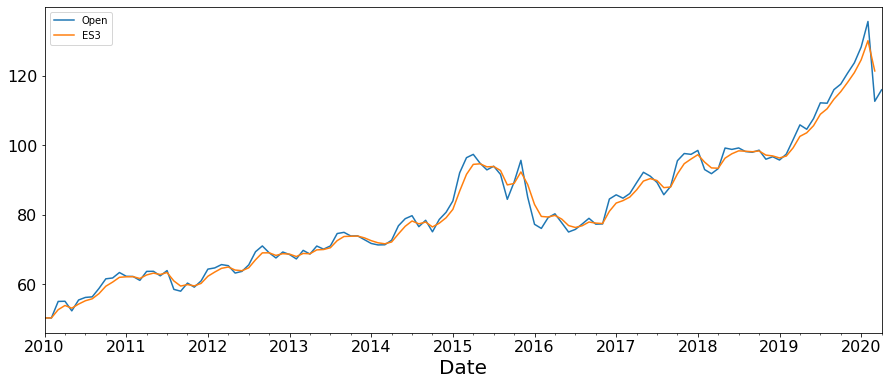

In [58]:
# Setting parameters value
span = 3
# Weights of observations
alpha = 2/(span+1)

# Plot Simple exponential smoothing
# Fit the model using SimpleExpSmoothing and set smoothing level alpha to alpha
# Shift the fitted values by one time step to plot them against the original data
y['ES3'] = SimpleExpSmoothing(y['Open']).fit(smoothing_level = alpha, optimized = False).fittedvalues.shift(-1)

# Plot the original 'Open' values and the Simple exponential smoothing fitted values
y[['Open','ES3']].plot(figsize=(15,6))

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


<AxesSubplot:xlabel='Date'>

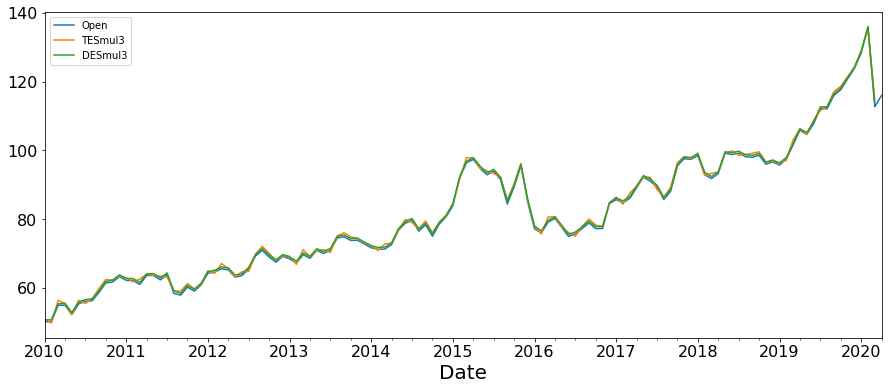

In [59]:
# Plot Double and Triple exponential smoothing

# Double Exponential Smoothing (Holt's Linear Method)
y['DESmul3'] = ExponentialSmoothing(y['Open'], trend='add').fit().fittedvalues.shift(-1)

# Triple Exponential Smoothing (Holt-Winters' Method)
y['TESmul3'] = ExponentialSmoothing(y['Open'], trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues.shift(-1)

# Plot the original time series and the two smoothed versions
y[['Open', 'TESmul3', 'DESmul3']].plot(figsize=(15, 6))

## FORECASTING WITH AUTO ARIMA

In [60]:
# Reverse index so the dataframe is from oldest to newest values
imputed_air_liquide = imputed_air_liquide.reindex(index=imputed_air_liquide.index[::-1])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


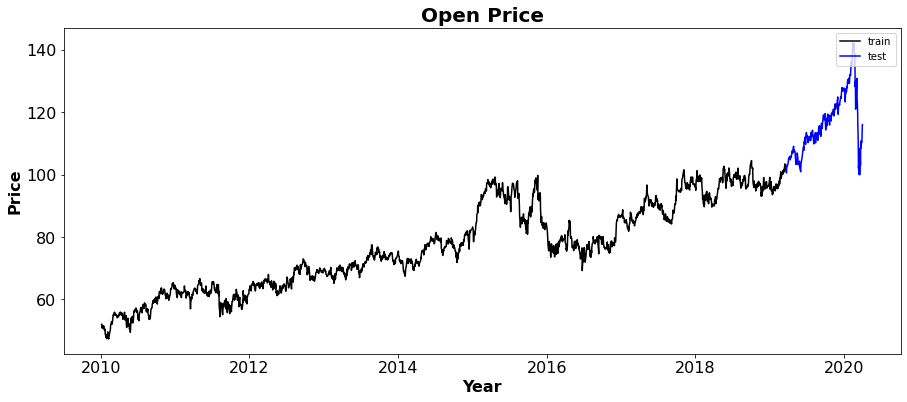

In [61]:
# Split data into train and validation set 90/10
air_liquide_train, air_liquide_val = imputed_air_liquide[:int(len(imputed_air_liquide)*0.9)], imputed_air_liquide[int(len(imputed_air_liquide)*0.9):]

# Set the index to the 'Date' column for both train and validation sets
air_liquide_val = air_liquide_val.set_index('Date', drop=False)
air_liquide_train = air_liquide_train.set_index('Date', drop=False)

# Plot the train and validation sets as separate lines
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(air_liquide_train['Date'], air_liquide_train['Open'], color = 'black')
sns.lineplot(air_liquide_val['Date'], air_liquide_val['Open'], color = 'blue')

# Formatting
ax.set_title('Open Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

In [64]:
model = ARIMA(air_liquide_train['Open'], order = (1, 1, 2))
# disp=-1: no output

fitted = model.fit(disp = -1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:                 2339
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3403.083
Method:                       css-mle   S.D. of innovations              1.036
Date:                Fri, 13 Oct 2023   AIC                           6816.166
Time:                        05:11:57   BIC                           6844.954
Sample:                             1   HQIC                          6826.653
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0195      0.002     10.373      0.000       0.016       0.023
ar.L1.D.Open     0.9865      0.004    276.705      0.000       0.980       0.994
ma.L1.D.Open    -1.1254      0.021    -52.37

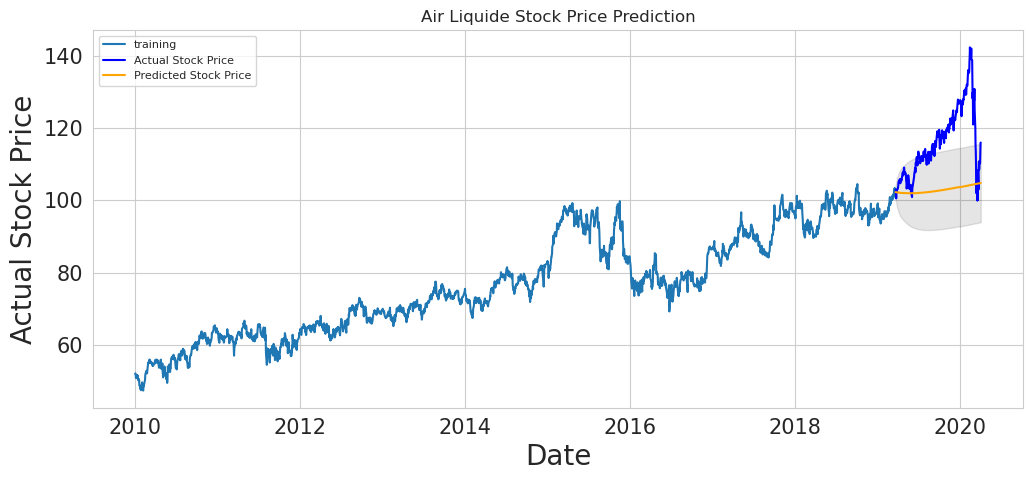

In [65]:
# Forecast 260 next observations 
fc, se, conf = fitted.forecast(260, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=air_liquide_val.index)
lower_series = pd.Series(conf[:, 0], index=air_liquide_val.index)
upper_series = pd.Series(conf[:, 1], index=air_liquide_val.index)

# Plotting the predicted and actual stock prices
plt.figure(figsize=(12,5), dpi=100)
plt.plot(air_liquide_train['Open'], label='training')
plt.plot(air_liquide_val['Open'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Air Liquide Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [66]:
# Report performances
mse = mean_squared_error(air_liquide_val['Open'], fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(air_liquide_val['Open'], fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(air_liquide_val['Open'], fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - air_liquide_val['Open'])/np.abs(air_liquide_val['Open']))
print('MAPE: '+str(mape))

MSE: 252.96451746779198
MAE: 13.214071768450133
RMSE: 15.90485829763321
MAPE: 0.10858160693463688
